In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Dropout, Concatenate
from keras.layers import LSTM, Embedding, Bidirectional, GRU
from keras.layers import SpatialDropout1D, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
import pickle
from sklearn.metrics import classification_report
import collections
from sklearn.utils.class_weight import compute_class_weight
from gensim import models

In [ ]:
import pandas as pd

TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/draw-data/Train.csv'
VAL_PATH = '/content/drive/MyDrive/Colab Notebooks/draw-data/Dev.csv'
TEST_PATH = '/content/drive/MyDrive/Colab Notebooks/draw-data/Test.csv'

ASPECTS = ['BATTERY', 'CAMERA', 'DESIGN', 'FEATURES', 'GENERAL', 'PERFORMANCE', 'PRICE', 'SCREEN', 'SER&ACC', 'STORAGE']
POLARITIES = {'Positive': 1, 'Negative': 2, 'Neutral': 3}



In [ ]:
df_train = pd.read_csv(TRAIN_PATH)
df_val   = pd.read_csv(VAL_PATH)
df_test  = pd.read_csv(TEST_PATH)

In [ ]:
df_train.head()

,index,comment,n_star,date_time,label
0,0,Mới mua máy này Tại thegioididong thốt nốt cảm...,5,2 tuần trước,{CAMERA#Positive};{FEATURES#Positive};{BATTERY...
1,1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,5,14/09/2019,{BATTERY#Negative};{GENERAL#Positive};{OTHERS};
2,2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,3,17/08/2020,{FEATURES#Negative};
3,3,"Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...",3,29/02/2020,{FEATURES#Negative};{BATTERY#Neutral};{GENERAL...
4,4,"Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...",5,4/6/2020,{BATTERY#Positive};{PERFORMANCE#Positive};{SER...


In [ ]:
df_test.head()

,index,comment,n_star,date_time,label
0,0,"Điện thoải ổn. Facelock cực nhanh, vân tay ôk ...",5,5/2/2020,{SCREEN#Positive};{FEATURES#Positive};{PERFORM...
1,1,"Mình mới mua vivo91c. Tải ứng dụng ,games nh...",5,14/05/2019,{FEATURES#Negative};{PERFORMANCE#Positive};{SE...
2,2,Xấu đẹp gì ko biết nhưng rất ưng TGdđ phục vụ ...,5,26/03/2020,{DESIGN#Neutral};{SER&ACC#Positive};
3,3,Màn hình hơi lác khi chơi game. Game nặng thì ...,4,4/6/2019,{PERFORMANCE#Negative};{DESIGN#Negative};{OTHE...
4,4,"Nói chung máy đẹp với màn amoled, ổn trong tầm...",4,12/5/2020,{SCREEN#Positive};{BATTERY#Negative};{DESIGN#P...


In [ ]:
!pip install underthesea
!pip install gensim
!pip install viet_text_tools
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 8.7 MB/s eta 0:00:00


In [ ]:
from underthesea import word_tokenize

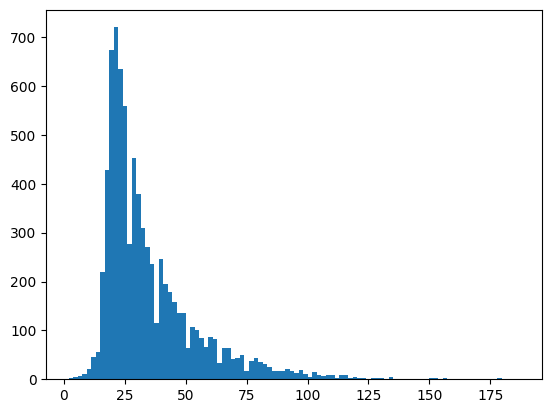

In [ ]:
plt.hist(df_train['comment'].apply(word_tokenize).str.len(), bins=100)
plt.show()

In [ ]:
SEQUENCE_LENGTH = 75

In [47]:
!pip3 install py_vncorenlp
from vncorenlp import VnCoreNLP


from nltk import flatten

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.7 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4306 sha256=659dbc614a4fe92ee80418f9eda44a729252af8105ca8626ac0775fc96c7e42a
  Stored in directory: /root/.cache/pip/wheels/d5/d9/bf/62632cdb007c702a0664091e92a0bb1f18a2fcecbe962d9827
Successfully built py_vncorenlp


In [49]:
import regex as re
import string
import emoji



# Xoá các tag HTML
def remove_HTML(text):
    return re.sub(r'<[^>]*>', '', text)


# Chuẩn hoá unicode
def convert_unicode(text):
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    char1252 = char1252.split('|')
    charutf8 = charutf8.split('|')

    dic = {}
    for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dic[x.group()], text
    )


# Standardize accent typing
vowels_to_ids = {}
vowels_table = [
    ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
    ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
    ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
    ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
    ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
    ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
    ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
    ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
    ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
    ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
    ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
    ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
]

for i in range(len(vowels_table)):
    for j in range(len(vowels_table[i]) - 1):
        vowels_to_ids[vowels_table[i][j]] = (i, j)


def is_valid_vietnamese_word(word):
    # Kiểm tra xem các ký tự nguyên âm có liền nhau hay không
    chars = list(word)
    vowel_indexes = -1
    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x != -1:
            if vowel_indexes == -1: vowel_indexes = index
            else:
                if index - vowel_indexes != 1: return False
                vowel_indexes = index
    return True


def standardize_word_typing(word):
    '''
    Chuẩn hoá các nguyên âm trong tiếng việt dựa trên nguyên
    tắc đặt dấu thanh trong chữ quốc ngữ (kiểu cũ)
    ==> Việc này giúp giảm thiểu các từ trong từ điển
    ==> Tăng performance.

    VD: gỉa, giả ==> Đưa về giả

    Tham khảo: https://vi.wikipedia.org/wiki/Quy_t%E1%BA%AFc_%C4%91%E1%BA%B7t_d%E1%BA%A5u_thanh_trong_ch%E1%BB%AF_qu%E1%BB%91c_ng%E1%BB%AF
    '''

    # Nếu không phải từ tiếng việt hợp lệ thì ta không cần chuẩn hoá các nguyên âm
    if not is_valid_vietnamese_word(word): return word
    chars = list(word)
    dau_cau = 0
    vowel_indexes = []
    qu_or_gi = False

    # Trong tiếng việt có 2 phụ âm kép có ký tự thành phần giống nguyên âm
    # là qu và gi, vì vậy ta cần tránh nhầm lẫn các ký tự u, i trong
    # qu và gi là nguyên âm.
    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x == -1: continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True

        # Nếu y != 0, thì từ sẽ có dấu câu (hỏi, ngã, nặng, ...)
        if y != 0:
            dau_cau = y
            chars[index] = vowels_table[x][0]

        # Nếu ký tự hiện tại nằm trong bảng nguyên âm
        # và không phải là ký tự trong phụ âm qu, gi thì ta
        # sẽ chèn vào vowel_indexes
        if not qu_or_gi or index != 1:
            vowel_indexes.append(index)

    # Trường hợp từ có 0 hoặc 1 nguyên âm
    if len(vowel_indexes) < 2:
        # Vì dấu thanh chỉ có khả năng trên nguyên âm, nên các trường hợp phụ âm
        # không phải qu hoặc gi ta chỉ cần trả về từ gốc.
        if qu_or_gi:
            # Ví dụ: gỉ sau đợt xử lý trên sẽ được tách thành list chas ['g', 'i']
            # và dau_cau = 3 (dấu hỏi) thì ta sẽ trả lại đúng thành gỉ
            if len(chars) == 2:
                x, y = vowels_to_ids.get(chars[1])
                chars[1] = vowels_table[x][dau_cau]

            # Nếu có 1 nguyên âm, thì nguyên âm này sẽ được trả về đúng dấu thanh ban đầu.
            # VD: "giả" hoặc "gỉa" ==> ['g', 'i', 'a'] và dấu câu là hỏi ==> giả
            else:
                x, y = vowels_to_ids.get(chars[2], (-1, -1))
                if x != -1: chars[2] = vowels_table[x][dau_cau]
                else: chars[1] = vowels_table[5][dau_cau] if chars[1] == 'i' else vowels_table[9][dau_cau]
            return ''.join(chars)
        return word

    # Ngoại lệ là chữ "ê" và "ơ" chiếm ưu tiên, bất kể vị trí.
    for index in vowel_indexes:
        x, y = vowels_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = vowels_table[x][dau_cau]
            return ''.join(chars)

    # Nếu là tập hợp hai (2) nguyên âm (nguyên âm đôi) thì đánh dấu ở nguyên âm đầu.
    # Tập hợp ba (3) nguyên âm (nguyên âm ba) hoặc hai nguyên âm + phụ âm cuối
    # thì vị trí dấu chuyển đến nguyên âm thứ nhì
    if len(vowel_indexes) == 2:
        if vowel_indexes[-1] == len(chars) - 1:
            x, y = vowels_to_ids[chars[vowel_indexes[0]]]
            chars[vowel_indexes[0]] = vowels_table[x][dau_cau]
        else:
            x, y = vowels_to_ids[chars[vowel_indexes[1]]]
            chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    else:
        x, y = vowels_to_ids[chars[vowel_indexes[1]]]
        chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    return ''.join(chars)


def standardize_sentence_typing(text):
    words = text.lower().split()
    for index, word in enumerate(words):
        # Dùng regex để tách thành cụm có dạng "<dấu câu>/<word>/<dấu câu>"
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        if len(cw) == 3: cw[1] = standardize_word_typing(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)


# Chuẩn hoá từ viết tắt
# !wget https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
replace_list = {
    'ô kêi': 'ok', 'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'ôkê': 'ok', 'oki': 'ok', 'oke': 'ok', 'okay': 'ok', 'okê': 'ok',
    'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
    'kg': 'không', 'not': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không', 'kp': 'không phải',
    'he he': 'tích cực', 'hehe': 'tích cực', 'hihi': 'tích cực', 'haha': 'tích cực', 'hjhj': 'tích cực', 'thick': 'tích cực',
    'lol': 'tiêu cực', 'cc': 'tiêu cực', 'huhu': 'tiêu cực', 'cute': 'dễ thương',

    'sz': 'cỡ', 'size': 'cỡ',
    'wa': 'quá', 'wá': 'quá', 'qá': 'quá',
    'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được', 'đc': 'được',
    'vs': 'với', 'j': 'gì', '“': ' ', 'time': 'thời gian', 'm': 'mình', 'mik': 'mình', 'r': 'rồi', 'bjo': 'bao giờ', 'very': 'rất',

    'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth': 'chuẩn chính hãng', 'date': 'hạn sử dụng', 'hsd': 'hạn sử dụng',
    'store': 'cửa hàng', 'sop': 'cửa hàng', 'shopE': 'cửa hàng', 'shop': 'cửa hàng',
    'sp': 'sản phẩm', 'product': 'sản phẩm', 'hàg': 'hàng',
    'ship': 'giao hàng', 'delivery': 'giao hàng', 'síp': 'giao hàng', 'order': 'đặt hàng',

    'gud': 'tốt', 'wel done': 'tốt', 'good': 'tốt', 'gút': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt',
    'quality': 'chất lượng', 'chất lg': 'chất lượng', 'chat': 'chất', 'excelent': 'hoàn hảo', 'bt': 'bình thường',
    'sad': 'tệ', 'por': 'tệ', 'poor': 'tệ', 'bad': 'tệ',
    'beautiful': 'đẹp tuyệt vời', 'dep': 'đẹp',
    'xau': 'xấu', 'sấu': 'xấu',

    'thik': 'thích', 'iu': 'yêu', 'fake': 'giả mạo',
    'quickly': 'nhanh', 'quick': 'nhanh', 'fast': 'nhanh',
    'fresh': 'tươi', 'delicious': 'ngon',

    'dt': 'điện thoại', 'fb': 'facebook', 'face': 'facebook', 'ks': 'khách sạn', 'nv': 'nhân viên',
    'nt': 'nhắn tin', 'ib': 'nhắn tin', 'tl': 'trả lời', 'trl': 'trả lời', 'rep': 'trả lời',
    'fback': 'feedback', 'fedback': 'feedback',
    'sd': 'sử dụng', 'sài': 'xài',

    '😊': 'tích cực', '🙂': 'tích cực', '🙁': 'tiêu cực',
    '❤️': 'tích cực', '👍': 'tích cực', '🎉': 'tích cực', '😀': 'tích cực', '😍': 'tích cực', '😂': 'tích cực', '🤗': 'tích cực', '😙': 'tích cực', '🙂': 'tích cực',
    '😔': 'tiêu cực', '😓': 'tiêu cực',
    '⭐': 'star', '*': 'star', '🌟': 'star'
}

with open('/content/drive/MyDrive/Colab Notebooks/teencode.txt', encoding='utf-8') as f:
    for pair in f.readlines():
        key, value = pair.split('\t')
        replace_list[key] = value.strip()


def normalize_acronyms(text):
    words = []
    for word in text.strip().split():
        # word = word.strip(string.punctuation)
        if word.lower() not in replace_list.keys(): words.append(word)
        else: words.append(replace_list[word.lower()])
    return emoji.demojize(' '.join(words)) # Remove Emojis


# Word segmentation
annotator = VnCoreNLP('/content/drive/MyDrive/Colab Notebooks/VnCoreNLP/VnCoreNLP-1.1.1.jar')
def word_segmentation(text):
    words = annotator.tokenize(text)
    return ' '.join(word for word in flatten(words))


# Xoá các ký tự không cần thiết
def remove_unnecessary_characters(text):
    text = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬÉÈẺẼẸÊẾỀỂỄỆÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÍÌỈĨỊÚÙỦŨỤƯỨỪỬỮỰÝỲỶỸỴĐ_]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    return text

def text_preprocess(text):
    text = remove_HTML(text)
    text = convert_unicode(text)
    text = standardize_sentence_typing(text)
    text = normalize_acronyms(text)
    text = word_segmentation(text) # When use PhoBERT
    text = remove_unnecessary_characters(text)
    return text.lower()
    return text

In [90]:
import pandas as pd

# def preprocess_dataframe(df):
#     df = df.drop(columns=['index', 'n_star', 'date_time'])
#     df = pd.concat([df, pd.DataFrame(columns=ASPECTS)])
#        # Duyệt qua từng dòng trong cột "comment" và áp dụng hàm text_preprocess
#     for index, row in df.iterrows():
#         comment = row['comment']
#         processed_comment = text_preprocess(comment)
#         df.at[index, 'comment'] = processed_comment
#     for index, label in enumerate(df['label']):
#         aspects_dict = dict.fromkeys(ASPECTS, 0)
#         #xu ly label
#         for category in label.split(';'):
#             try:

#                 aspect, sentiment = category.replace('{', '').replace('}', '').split('#')
#                 #loại bỏ kí tự và tách chuỗi thành 2 phần dựa trên #,
#                 #aspect='khía cạnh'
#                 #sentiment='cảm xúc'
#             except:
#                 continue
#             aspects_dict[aspect] = POLARITIES[sentiment]
#             #POLARITIES = {'Positive': 1, 'Negative': 2, 'Neutral': 3}
#             df.loc[index, ASPECTS] = list(aspects_dict.values())
#     return df
import pandas as pd

def preprocess_dataframe(df):
    df = df.drop(columns=['index', 'n_star', 'date_time'])
    df = pd.concat([df, pd.DataFrame(columns=ASPECTS)])

    for index, row in df.iterrows():
        comment = row['comment']
        processed_comment = text_preprocess(comment)
        df.at[index, 'comment'] = processed_comment

    for index, row in df.iterrows():
        aspects_dict = dict.fromkeys(ASPECTS, 0)
        label = row['label']

        if not pd.isna(label):
            categories = label.split(';')
            for category in categories:
                try:
                    aspect, sentiment = category.replace('{', '').replace('}', '').split('#')
                    aspects_dict[aspect] = POLARITIES.get(sentiment, 0)
                except:
                    continue

        df.loc[index, ASPECTS] = list(aspects_dict.values())

    return df

# ============================================================================ #

def get_word2id(dfs):
  word2id = {}
  index = 1
  for df in dfs:
    for sentence in df['comment']:
      words = sentence.split()
      for word in words:
        if (word not in word2id) and (word != ''):
          word2id[word] = index
          index += 1
  return word2id

def indexing(sentence, word2id):
  words = sentence.split()
  ids = [word2id[word] if word in word2id.keys() else 0 for word in words]
  return np.array(ids)

def indexing_dataset(sentences, word2id):
  pos = [indexing(sentence, word2id) for sentence in sentences]
  return np.array(pos, dtype=object)

# ============================================================================ #

def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(2, len(df.columns)):
            sentiment = df.iloc[row, col]
            if sentiment == 0:
              one_hot = [1, 0, 0, 0] # None
            elif sentiment == 1:
              one_hot = [0, 1, 0, 0] # Pos
            elif sentiment == 2:
              one_hot = [0, 0, 1, 0] # Neg
            elif sentiment == 3:
              one_hot = [0, 0, 0, 1] # Neu
            else:
              one_hot = [0, 0, 0, 0]
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    outputs = np.array(outputs, dtype='uint8')
    return outputs.reshape(len(df), -1)

In [51]:
train_df = preprocess_dataframe(df_train)
train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/prepprocessed-data/TrainPrep.csv', index=False)
val_df   = preprocess_dataframe(df_val)
val_df.to_csv('/content/drive/MyDrive/Colab Notebooks/prepprocessed-data/DevPrep.csv', index=False)
test_df  = preprocess_dataframe(df_test)
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/prepprocessed-data/TestPrep.csv', index=False)

In [91]:
train_df.head()

,comment,label,BATTERY,CAMERA,DESIGN,FEATURES,GENERAL,PERFORMANCE,PRICE,SCREEN,SER&ACC,STORAGE
0,mới mua máy này tại thegioididong thốt_nốt cảm...,{CAMERA#Positive};{FEATURES#Positive};{BATTERY...,1,1,0,1,1,0,1,0,1,0
1,pin kém còn lại miễn chê mua 832019 tình_trạng...,{BATTERY#Negative};{GENERAL#Positive};{OTHERS};,2,0,0,0,1,0,0,0,0,0
2,sao lúc gọi điện_thoại màn_hình bị chấm nhỏ nh...,{FEATURES#Negative};,0,0,0,2,0,0,0,0,0,0
3,mọi người cập_nhật phần_mềm lại nó sẽ bớt tốn ...,{FEATURES#Negative};{BATTERY#Neutral};{GENERAL...,3,0,0,2,3,0,0,0,0,0
4,mới mua xài được 1 tháng thấy pin rất trâu xài...,{BATTERY#Positive};{PERFORMANCE#Positive};{SER...,1,0,0,0,0,1,0,0,2,0


In [93]:
test_df.head()

,comment,label,BATTERY,CAMERA,DESIGN,FEATURES,GENERAL,PERFORMANCE,PRICE,SCREEN,SER&ACC,STORAGE
0,điện thoải ổn facelock cực nhanh vân tay ôk mà...,{SCREEN#Positive};{FEATURES#Positive};{PERFORM...,0,0,0,1,1,1,0,1,0,0
1,mình mới mua vivo91c tải ứng_dụng games nhanh ...,{FEATURES#Negative};{PERFORMANCE#Positive};{SE...,0,0,0,2,0,1,0,0,1,0
2,xấu đẹp gì không biết nhưng rất ưng tgdđ phục_...,{DESIGN#Neutral};{SER&ACC#Positive};,0,0,3,0,0,0,0,0,1,0
3,màn_hình hơi lác khi chơi game game nặng thì m...,{PERFORMANCE#Negative};{DESIGN#Negative};{OTHE...,0,0,2,0,0,2,0,0,0,0
4,nói_chung máy đẹp với màn amoled ổn trong tầm ...,{SCREEN#Positive};{BATTERY#Negative};{DESIGN#P...,2,0,1,0,0,0,0,1,0,0


In [94]:


WORD2ID_PKL = '/content/drive/MyDrive/Colab Notebooks/output/word2id.pkl'
MODEL_PATH  = '/content/drive/MyDrive/Colab Notebooks/output/abc.h5'


In [95]:
X_train, X_val, X_test = train_df['comment'], val_df['comment'], test_df['comment']
y_train, y_val, y_test = make_outputs(train_df), make_outputs(val_df), make_outputs(test_df)

In [96]:
# Save pickle
word2id = get_word2id([train_df, val_df, test_df])
print(word2id)
with open(WORD2ID_PKL, 'wb') as f:
  pickle.dump(word2id, f, protocol=pickle.HIGHEST_PROTOCOL)

{'mới': 1, 'mua': 2, 'máy': 3, 'này': 4, 'tại': 5, 'thegioididong': 6, 'thốt_nốt': 7, 'cảm_thấy': 8, 'ok': 9, 'bin': 10, 'trâu': 11, 'chụp': 12, 'ảnh': 13, 'đẹp': 14, 'loa': 15, 'nghe': 16, 'to': 17, 'bắt': 18, 'wf': 19, 'khoẻ': 20, 'sóng': 21, 'ổn_định': 22, 'giá_thành': 23, 'vừa': 24, 'với': 25, 'túi_tiền': 26, 'nhân_viên': 27, 'tư_vấn': 28, 'nhiệt_tình': 29, 'pin': 30, 'kém': 31, 'còn': 32, 'lại': 33, 'miễn': 34, 'chê': 35, '832019': 36, 'tình_trạng': 37, '88': 38, 'có': 39, 'ai': 40, 'giống': 41, 'tôi': 42, 'không': 43, 'sao': 44, 'lúc': 45, 'gọi': 46, 'điện_thoại': 47, 'màn_hình': 48, 'bị': 49, 'chấm': 50, 'nhỏ': 51, 'nháy': 52, 'gần': 53, 'camera': 54, 'trước': 55, 'vậy': 56, 'mọi': 57, 'người': 58, 'cập_nhật': 59, 'phần_mềm': 60, 'nó': 61, 'sẽ': 62, 'bớt': 63, 'tốn': 64, 'mình': 65, 'đã': 66, 'thử': 67, 'rồi': 68, 'thứ': 69, 'cũng': 70, 'nhưng': 71, 'vân': 72, 'tay_không': 73, 'nhạy': 74, 'xài': 75, 'được': 76, '1': 77, 'tháng': 78, 'thấy': 79, 'rất': 80, 'bao': 81, 'mượt': 82, 

In [97]:
# Load pickle
with open(WORD2ID_PKL, 'rb') as f:
  word2id = pickle.load(f)

In [98]:
!pip install keras

In [99]:
from tensorflow.keras.preprocessing import sequence as sq

X_train = indexing_dataset(X_train, word2id)
X_train = sq.pad_sequences(X_train, maxlen=SEQUENCE_LENGTH)

X_val = indexing_dataset(X_val, word2id)
X_val = sq.pad_sequences(X_val, maxlen=SEQUENCE_LENGTH)

X_test = indexing_dataset(X_test, word2id)
X_test = sq.pad_sequences(X_test, maxlen=SEQUENCE_LENGTH)

In [100]:
print(f'X shape: \t X_train={X_train.shape}\t X_val={X_val.shape}\t X_test={X_test.shape}')
print(f'y shape: \t y_train={y_train.shape}\t y_val={y_val.shape}\t y_test={y_test.shape}')

X shape: 	 X_train=(7786, 75)	 X_val=(1112, 75)	 X_test=(2224, 75)
y shape: 	 y_train=(7786, 40)	 y_val=(1112, 40)	 y_test=(2224, 40)


## 3. Train model

In [101]:
!pip install underthesea


In [102]:
def save_figures(h, path):
  plt.figure(figsize=(15,5))
  plt.subplot(1, 2, 1)
  plt.plot(h.history['accuracy'])
  plt.plot(h.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='lower right')
  plt.subplot(1, 2, 2)
  plt.plot(h.history['loss'])
  plt.plot(h.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.savefig(path)
  plt.close()

In [103]:
ACC_LOSS     = '/content/drive/MyDrive/Colab Notebooks/output/figures/absa_bi-lstm.png'
ARCHITECTURE = '/content/drive/MyDrive/Colab Notebooks/output/figures/architecture.png'

In [104]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, Bidirectional, LSTM, Conv1D, GlobalAveragePooling1D, GlobalMaxPool1D, Dense, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [105]:
input_layer = Input(shape=(SEQUENCE_LENGTH,), dtype='int32')

embed_layer = Embedding(21669, 256, input_length=SEQUENCE_LENGTH)(input_layer)  # (DICTIONARY_SIZE + 1, EMBEDDING_DIMS)

spatial_dropout_layer = SpatialDropout1D(0.2)(embed_layer)

bidirectional_layer = Bidirectional(LSTM(10, return_sequences=True))(spatial_dropout_layer)

conv1d_layer = Conv1D(32, 1, activation='relu')(bidirectional_layer)

global_avg_pool_layer = GlobalAveragePooling1D()(conv1d_layer)
global_max_pool_layer = GlobalMaxPool1D()(conv1d_layer)
concat_layer = Concatenate(axis=1)([global_avg_pool_layer, global_max_pool_layer])

output_layer = Concatenate(axis=1)([Dense(units=4, activation='softmax', name=aspect.replace('&', '_'))(concat_layer) for aspect in ASPECTS])

model = Model(inputs=[input_layer], outputs=[output_layer])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

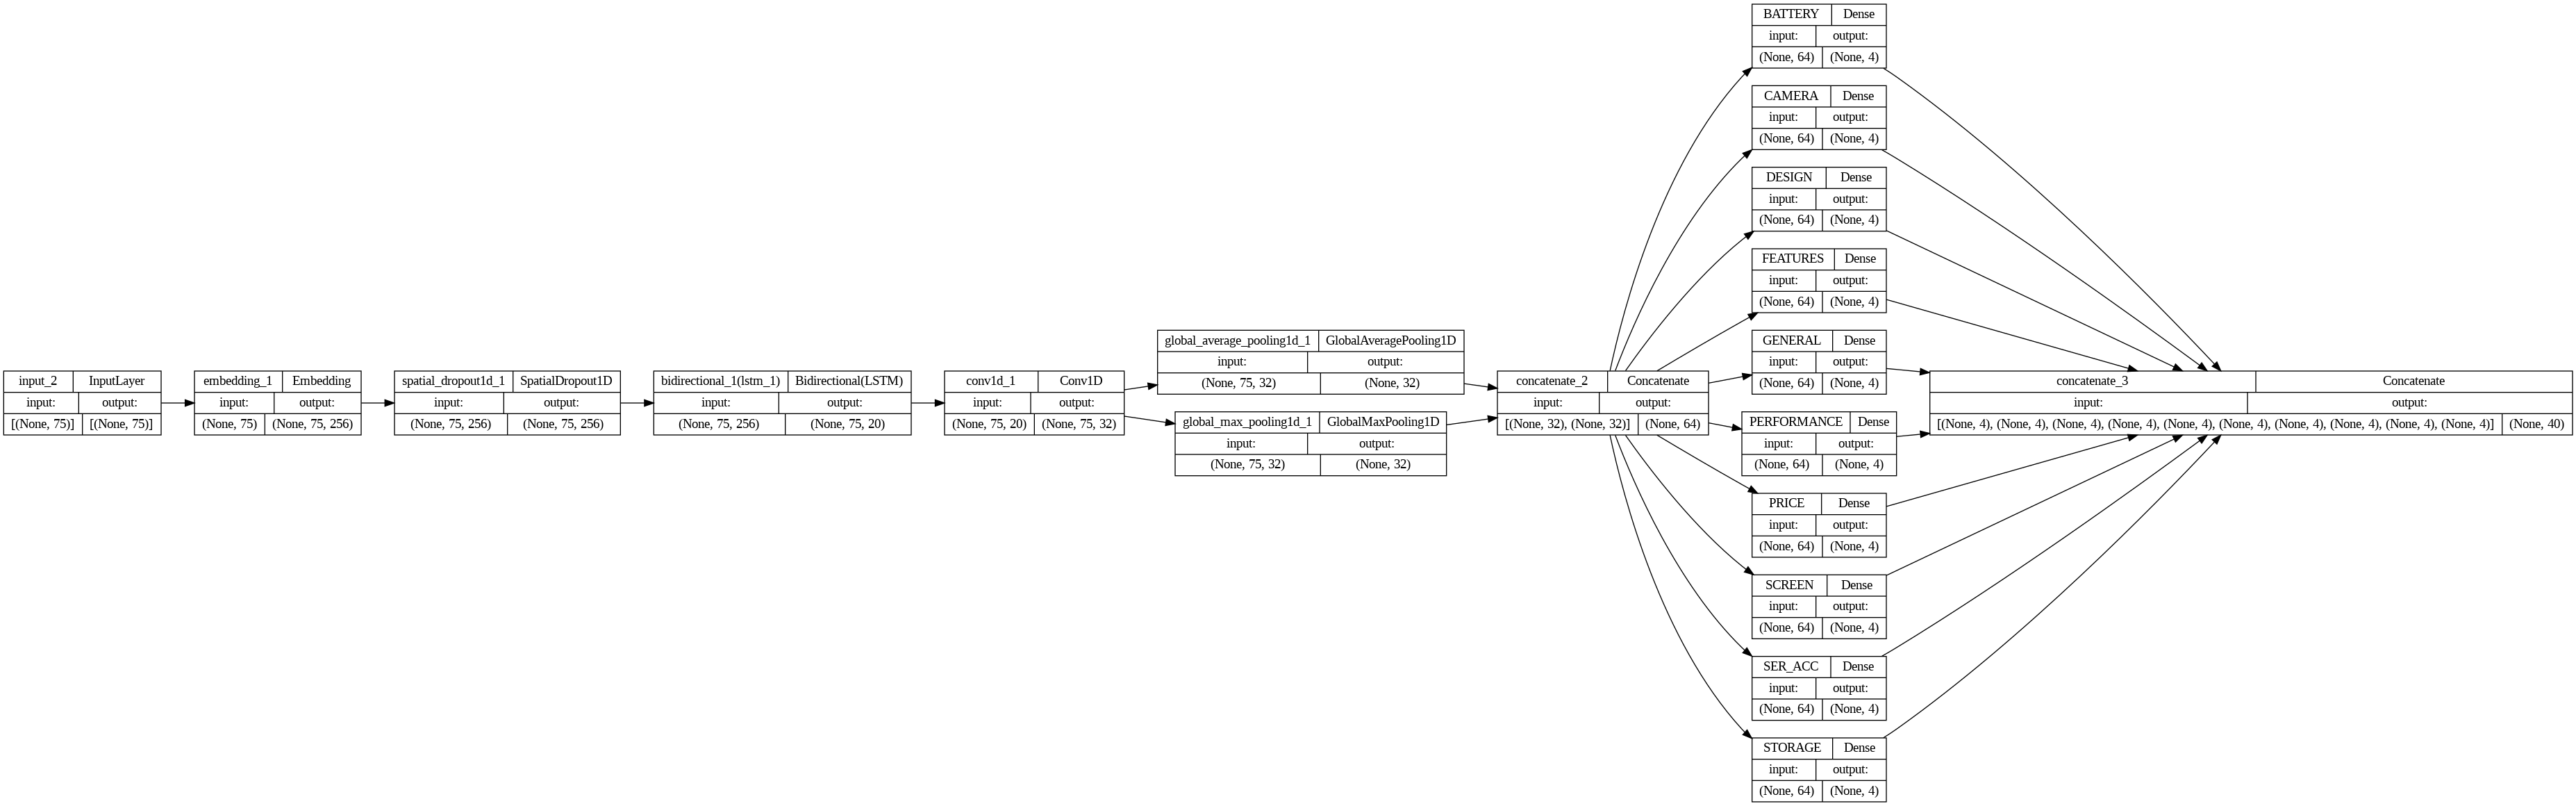

In [106]:
plot_model(model, to_file=ARCHITECTURE, show_shapes=True, rankdir='LR', dpi=96)

In [107]:
df_train.head()

,index,comment,n_star,date_time,label
0,0,Mới mua máy này Tại thegioididong thốt nốt cảm...,5,2 tuần trước,{CAMERA#Positive};{FEATURES#Positive};{BATTERY...
1,1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,5,14/09/2019,{BATTERY#Negative};{GENERAL#Positive};{OTHERS};
2,2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,3,17/08/2020,{FEATURES#Negative};
3,3,"Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...",3,29/02/2020,{FEATURES#Negative};{BATTERY#Neutral};{GENERAL...
4,4,"Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...",5,4/6/2020,{BATTERY#Positive};{PERFORMANCE#Positive};{SER...


In [108]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 75)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 75, 256)              5547264   ['input_2[0][0]']             
                                                                                                  
 spatial_dropout1d_1 (Spati  (None, 75, 256)              0         ['embedding_1[0][0]']         
 alDropout1D)                                                                                     
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 75, 20)               21360     ['spatial_dropout1d_1[0]

In [109]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
model_checkpoint = ModelCheckpoint(MODEL_PATH, monitor='val_loss', save_best_only=True, mode='min')

history = model.fit(x=X_train, y=y_train,
                    batch_size=16,
                    epochs=50,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])
save_figures(history, ACC_LOSS)

Epoch 1/50
487/487 [==============================] - ETA: 0s - loss: 0.3052 - accuracy: 5.1374e-04

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


487/487 [==============================] - 37s 59ms/step - loss: 0.3052 - accuracy: 5.1374e-04 - val_loss: 0.2288 - val_accuracy: 8.9928e-04
Epoch 2/50
487/487 [==============================] - 11s 23ms/step - loss: 0.2081 - accuracy: 0.0157 - val_loss: 0.1872 - val_accuracy: 0.0261
Epoch 3/50
487/487 [==============================] - 9s 19ms/step - loss: 0.1690 - accuracy: 0.0470 - val_loss: 0.1712 - val_accuracy: 0.0899
Epoch 4/50
487/487 [==============================] - 9s 18ms/step - loss: 0.1443 - accuracy: 0.0836 - val_loss: 0.1652 - val_accuracy: 0.0629
Epoch 5/50
487/487 [==============================] - 9s 18ms/step - loss: 0.1255 - accuracy: 0.0923 - val_loss: 0.1622 - val_accuracy: 0.1025
Epoch 6/50
487/487 [==============================] - 7s 14ms/step - loss: 0.1110 - accuracy: 0.0803 - val_loss: 0.1660 - val_accuracy: 0.1079
Epoch 7/50
487/487 [==============================] - 9s 19ms/step - loss: 0.0988 - accuracy: 0.0679 - val_loss: 0.1682 - val_accuracy: 0.0737


In [110]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

In [111]:
REPLACEMENTS = {0: None, 1: 'Positive', 2: 'Negative', 3: 'Neutral'}
model = load_model(MODEL_PATH)

In [112]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(len(y_pred), -1, 4)
y_pred_argmax = np.argmax(y_pred, axis=-1)

y_test = y_test.reshape(len(y_test), -1, 4)
y_test_argmax = np.argmax(y_test, axis=-1)

aspect_test = []
aspect_pred = []
for row_test, row_pred in zip(y_test_argmax, y_pred_argmax):
  for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
    aspect_test.append(bool(col_test) * ASPECTS[index])
    aspect_pred.append(bool(col_pred) * ASPECTS[index])

70/70 [==============================] - 1s 5ms/step


In [113]:
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1)
print(aspect_report)

              precision    recall  f1-score   support

                 0.9219    0.9535    0.9374     15518
     BATTERY     0.9543    0.9477    0.9510      1014
      CAMERA     0.9169    0.9201    0.9185       588
      DESIGN     0.8705    0.6080    0.7160       398
    FEATURES     0.8474    0.8045    0.8254       711
     GENERAL     0.8342    0.8125    0.8232      1381
 PERFORMANCE     0.8941    0.8575    0.8754      1172
       PRICE     0.9024    0.8770    0.8895       569
      SCREEN     0.7982    0.3234    0.4603       269
     SER&ACC     0.8627    0.7420    0.7978       593
     STORAGE     1.0000    0.0000    0.0000        27

    accuracy                         0.9112     22240
   macro avg     0.8912    0.7133    0.7450     22240
weighted avg     0.9096    0.9112    0.9078     22240



In [ ]:
# Import thư viện và hàm dự đoán
import numpy as np

# Hàm dự đoán
def predict_aspect(sentences):
    # Tiến hành xử lý văn bản và chuyển nó thành dữ liệu có thể đưa vào mô hình
    # ...

    # Dự đoán các khía cạnh
    y_pred = model.predict(processed_sentences)
    y_pred = y_pred.reshape(len(y_pred), -1, 4)
    y_pred_argmax = np.argmax(y_pred, axis=-1)

    aspects_predicted = []
    for row_pred in y_pred_argmax:
        aspect = ASPECTS[np.argmax(row_pred)]
        aspects_predicted.append(aspect)

    return aspects_predicted

# Câu văn bản mẫu bạn muốn dự đoán
sample_text = "Máy tính này rất tốt và màn hình sắc nét."

# Dự đoán các khía cạnh của câu văn bản mẫu
predicted_aspects = predict_aspect([sample_text])

print("Các khía cạnh dự đoán:")
for aspect in predicted_aspects:
    print(aspect)


In [117]:
y_test_flat = y_test_argmax.flatten()
y_pred_flat = y_pred_argmax.flatten()
target_names = list(map(str, REPLACEMENTS.values()))

In [118]:
polarity_report = classification_report(y_test_flat, y_pred_flat, digits=4, zero_division=1, target_names=target_names)
print(polarity_report)

              precision    recall  f1-score   support

        None     0.9219    0.9535    0.9374     15518
    Positive     0.7832    0.7919    0.7875      3695
    Negative     0.6831    0.6262    0.6534      2210
     Neutral     0.6061    0.3182    0.4173       817

    accuracy                         0.8708     22240
   macro avg     0.7486    0.6725    0.6989     22240
weighted avg     0.8635    0.8708    0.8652     22240



In [119]:
def print_absa_pred(replacements, categories, sentence_pred):
  sentiments = map(lambda x: replacements[x], sentence_pred)
  for category, sentiment in zip(categories, sentiments):
    if sentiment:
      print(f'=> {category}\t{sentiment}')

In [121]:
START, END = 0, 50
for i in range(START, END):
  print('\nExample:', test_df['comment'][i])
  print_absa_pred(REPLACEMENTS, ASPECTS, y_pred_argmax[i])


Example: điện thoải ổn facelock cực nhanh vân tay ôk màn_hình lớn pin trâu liên_quân zalo youtube một ngày mất khoảng 45 tuy chỉ chip 439 nhưng rất mượt đa_nhiệm khá ổn
=> BATTERY	Positive
=> DESIGN	Positive
=> FEATURES	Positive
=> GENERAL	Positive
=> PERFORMANCE	Positive
=> SCREEN	Positive

Example: mình mới mua vivo91c tải ứng_dụng games nhanh có cái không hài_lòng là cài hình nền khoá màn_hình không được hay tại mình chưa biết hết chức_năng của nó tư_vấn_viên nhiệt_tình
=> FEATURES	Negative
=> PERFORMANCE	Negative
=> SER&ACC	Positive

Example: xấu đẹp gì không biết nhưng rất ưng tgdđ phục_vụ rất tuyệt_vời mua ở tgdđ mòn đít và sẽ mua dài_dài ủng_hộ tgdđ
=> DESIGN	Positive
=> SER&ACC	Positive

Example: màn_hình hơi lác khi chơi game game nặng thì mình chưa chơi nhưng_mà ở dưới có 2 bên loa ngoài sao nó dùng có 1 bên vậy cho mình hỏi máy các bạn cũng vậy hả hay máy mình bị lỗi
=> PERFORMANCE	Negative

Example: nói_chung máy đẹp với màn amoled ổn trong tầm giá hơi tiếc là thời_lượng p